# Visualizing the Data Analysis LangGraph Application

This notebook demonstrates how to visualize the graph structure of our LangGraph-based 
data analysis application using the ipykernel in VSCode.

The visualization helps understand the workflow nodes and connections between them.

In [ ]:
# Import necessary libraries
import sys
from pathlib import Path
from IPython.display import Image, display

# Add parent directory to path to import our application modules
current_dir = Path.cwd()
if str(current_dir) not in sys.path:
    sys.path.append(str(current_dir))

# Import our application
from my_agent import create_graph

## Create and Visualize the Graph

Now we'll create our application graph and visualize it using Graphviz.

In [2]:
# Create the graph
graph = create_graph()

# Get the underlying graph object
graph_obj = graph.get_graph()

# Print some basic information about the graph
print(f"Graph nodes: {graph_obj.nodes}")
print(f"Graph edges: {list(graph_obj.edges)}")

Graph nodes: {'__start__': Node(id='__start__', name='__start__', data=RunnablePassthrough(), metadata=None), 'list_columns': Node(id='list_columns', name='list_columns', data=list_columns(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'get_schema': Node(id='get_schema', name='get_schema', data=get_schema(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'model_get_schema': Node(id='model_get_schema', name='model_get_schema', data=model_get_schema(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'query_gen': Node(id='query_gen', name='query_gen', data=query_gen(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), 'correct_query': Node(id='correct_query', name='correct_query', data=correct_query(tags=None, recurse=True, explode_args=False, func_accepts_config=False,

## Alternative: Visualize Using Mermaid

If Graphviz isn't working, we can also use Mermaid syntax to visualize our graph.

In [3]:
# Generate Mermaid syntax representation of the graph
mermaid_syntax = graph_obj.draw_mermaid()
print(mermaid_syntax)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	list_columns(list_columns)
	get_schema(get_schema)
	model_get_schema(model_get_schema)
	query_gen(query_gen)
	correct_query(correct_query)
	execute_query(execute_query)
	submit_final_answer(submit_final_answer)
	save(save)
	__end__([<p>__end__</p>]):::last
	__start__ --> list_columns;
	correct_query --> execute_query;
	execute_query --> query_gen;
	get_schema --> query_gen;
	list_columns --> model_get_schema;
	model_get_schema --> get_schema;
	query_gen -.-> correct_query;
	query_gen -.-> submit_final_answer;
	submit_final_answer --> save;
	query_gen -.-> __end__;
	save --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



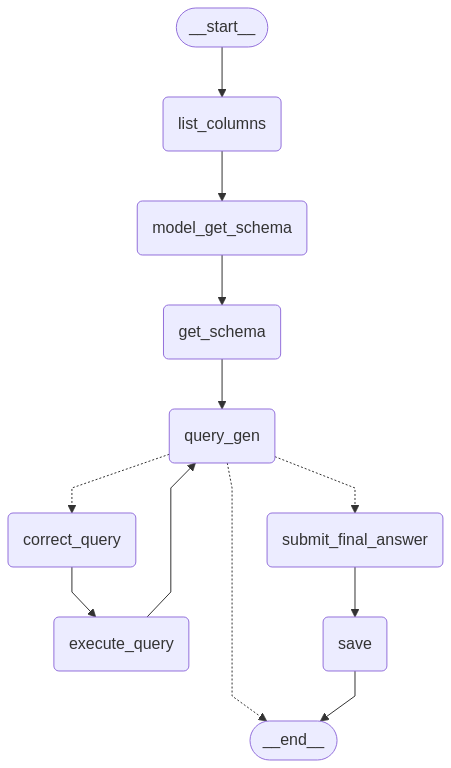

In [ ]:
# Alternative: Using Mermaid.Ink API to render as PNG
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

try:
    # Generate and display a PNG visualization using Mermaid.Ink API
    mermaid_png = graph_obj.draw_mermaid_png(
        draw_method=MermaidDrawMethod.API,
        curve_style=CurveStyle.LINEAR,
        node_colors=NodeStyles(first="#ffdfba", last="#baffc9", default="#f2f0ff")
    )
    display(Image(mermaid_png))
except Exception as e:
    print(f"Error visualizing graph with Mermaid.Ink API: {e}")
    print("This error is common if API access is blocked or restricted.")